In [1]:
import cirq
import matplotlib.pyplot as plt
import sinter
import stim
from stimcirq import cirq_circuit_to_stim_circuit

from tqec.constructions.qubit import ScalableQubitSquare
from tqec.detectors.gate import ShiftCoordsGate
from tqec.detectors.transformer import fill_in_global_record_indices
from tqec.enums import PlaquetteOrientation
from tqec.generation.circuit import generate_circuit
from tqec.noise_models import (
    DepolarizingNoiseOnIdlingQubit,
    MultiQubitDepolarizingNoiseAfterMultiQubitGate,
    XNoiseAfterReset,
    XNoiseBeforeMeasurement,
)
from tqec.plaquette.library import (
    XXXXPlaquette,
    ZZZZPlaquette,
)
from tqec.plaquette.library.xx import XXPlaquette
from tqec.plaquette.library.zz import ZZPlaquette
from tqec.detectors.gate import ObservableGate, RelativeMeasurement
from tqec.position import Shape2D

In [2]:
def normalise_circuit(circuit: cirq.Circuit) -> cirq.Circuit:
    ordered_transformers = [
        cirq.drop_empty_moments,
    ]
    for transformer in ordered_transformers:
        circuit = transformer(circuit)
    return circuit


def to_noisy_circuit(circuit: cirq.Circuit, noise_level: float) -> cirq.Circuit:
    noise_models = [
        XNoiseBeforeMeasurement(noise_level),
        MultiQubitDepolarizingNoiseAfterMultiQubitGate(noise_level),
        XNoiseAfterReset(noise_level),
        DepolarizingNoiseOnIdlingQubit(noise_level),
    ]
    for nm in noise_models:
        circuit = circuit.with_noise(nm)
    return circuit

In [3]:
def generate_cirq_circuit_tqec(dimension: int, repetitions: int) -> cirq.Circuit:
    template = ScalableQubitSquare(dimension)
    plaquettes = [
        ZZPlaquette(PlaquetteOrientation.UP),
        XXPlaquette(
            PlaquetteOrientation.LEFT, include_initial_and_final_detectors=False
        ),
        ZZZZPlaquette(),
        XXXXPlaquette(include_initial_and_final_detectors=False),
        XXPlaquette(
            PlaquetteOrientation.RIGHT, include_initial_and_final_detectors=False
        ),
        ZZPlaquette(PlaquetteOrientation.DOWN),
    ]

    def make_repeated_layer(circuit: cirq.Circuit) -> cirq.Circuit:
        any_qubit = next(iter(circuit.all_qubits()), None)
        assert (
            any_qubit is not None
        ), "Could not find any qubit in the given Circuit instance."
        circuit_to_repeat = (
            cirq.Circuit([ShiftCoordsGate(0, 0, 1).on(any_qubit)]) + circuit
        )
        repeated_circuit_operation = cirq.CircuitOperation(
            circuit_to_repeat.freeze()
        ).repeat(repetitions)
        return cirq.Circuit([repeated_circuit_operation])

    layer_modificators = {1: make_repeated_layer}

    circuit = cirq.Circuit()
    for layer_index in range(3):
        layer_circuit = generate_circuit(template, plaquettes, layer_index=layer_index)
        layer_circuit = normalise_circuit(layer_circuit)
        circuit += layer_modificators.get(layer_index, lambda circ: circ)(layer_circuit)

    # Compute the qubits that should be measured to get the Z logical operator.
    plaquette_shape: Shape2D = plaquettes[0].shape
    assert all(
        p.shape == plaquette_shape for p in plaquettes
    ), "All plaquettes should have exactly the same shape for the moment."
    vertical_center_index: int = (1 + dimension // 2) * (plaquette_shape.y - 1)
    origin = cirq.GridQubit(vertical_center_index, plaquette_shape.x - 1)
    circuit.append(
        [
            ObservableGate(
                origin,
                [
                    RelativeMeasurement(
                        cirq.GridQubit(0, i * (plaquette_shape.x - 1)), -1
                    )
                    for i in range(dimension + 1)
                ],
            ).on(origin)
        ]
    )

    circuit_with_detectors = fill_in_global_record_indices(circuit)
    return circuit_with_detectors

In [4]:
def generate_stim_circuit_tqec(
    code_distance: int, noise_level: float, repetitions: int
) -> stim.Circuit:
    circuit_with_detectors = generate_cirq_circuit_tqec(code_distance - 1, repetitions)
    noisy_circuit = to_noisy_circuit(circuit_with_detectors, noise_level)

    return cirq_circuit_to_stim_circuit(noisy_circuit)

In [5]:
stim_circuit = generate_stim_circuit_tqec(11, 0.001, 30)

In [6]:
def generate_stim_circuit_stim(
    code_distance: int, noise_level: float, repetitions: int
) -> stim.Circuit:
    return stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=repetitions - 1,
        distance=code_distance,
        after_clifford_depolarization=noise_level,
        after_reset_flip_probability=noise_level,
        before_measure_flip_probability=noise_level,
        before_round_data_depolarization=noise_level,
    )

## TQEC plots

In [7]:
surface_code_tasks_tqec = [
    sinter.Task(
        circuit=generate_stim_circuit_tqec(d, noise, 3 * d),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.008, 0.009, 0.01, 0.011]
]

collected_surface_code_stats_tqec: list[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks_tqec,
    decoders=["pymatching"],
    max_shots=100_000,
    max_errors=5_000,
    print_progress=False,
)

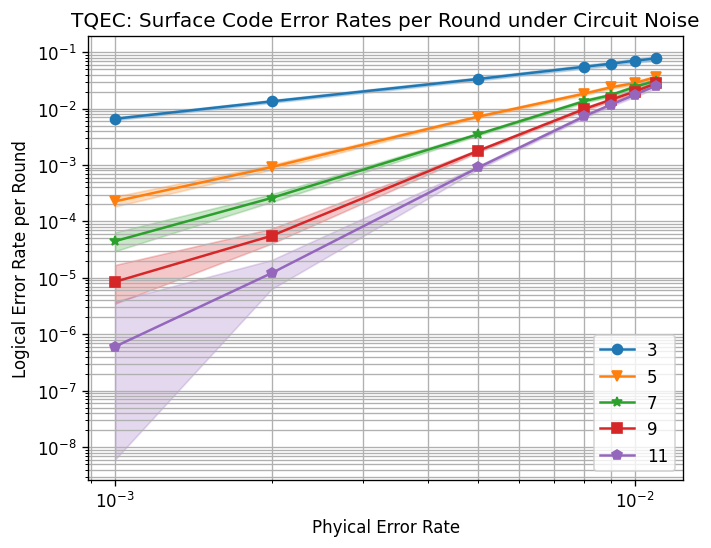

In [8]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_tqec,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("TQEC: Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger

## Stim plots

In [9]:
surface_code_tasks_stim = [
    sinter.Task(
        circuit=generate_stim_circuit_stim(d, noise, 3 * d),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.008, 0.009, 0.01, 0.011]
]

collected_surface_code_stats_stim: list[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks_stim,
    decoders=["pymatching"],
    max_shots=100_000,
    max_errors=5_000,
    print_progress=False,
)

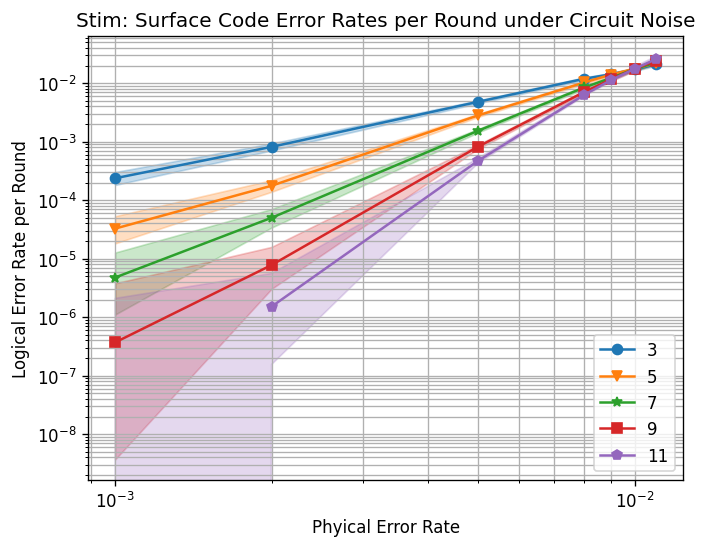

In [10]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_stim,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("Stim: Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger